In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **In This Project i have implemented word2vec skipgram method with Keras API and Trained the model with ferdosi poems mesras**

**Import the Necessary Libraries**

In [3]:
from keras.preprocessing import text
from keras.preprocessing.sequence import skipgrams
import numpy as np
from keras.layers import Dense, Reshape, Input, Embedding, Multiply, dot
from keras.models import Sequential
from keras import Model
from sklearn.metrics.pairwise import cosine_distances
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from random import shuffle

Using TensorFlow backend.


**Now , Read The text File of Ferdosi Poems and split the first mesras and second mesras to words**

In [0]:

sher = np.loadtxt('/content/drive/My Drive/Colab Notebooks/Deep Course/ferdosi.txt', dtype= 'str', delimiter= ',')


sher_charac_first = []
sher_charac_second_input = []



for l in range(len(sher)):

    first_mes = sher[l][0].split(' ') # split the sentences of first mesra to characters
    first_mes.remove('')#remove the space
    sher_charac_first.append(first_mes)

    second_mes_in = sher[l][1].split(' ')# split the sentences of second mesra to characters
    second_mes_in.remove('')#remove the space
    sher_charac_second_input.append(second_mes_in)

In [5]:
sher_charac_first[0], sher_charac_second_input[0]

(['به', 'نام', 'خداوند', 'جان', 'و', 'خرد'],
 ['کزین', 'برتر', 'اندیشه', 'برنگذرد'])

**Get the all characters according to the mesras**

In [0]:
sher = sher_charac_first + sher_charac_second_input 

for i in range(len(sher)):
    if '' in sher[i]:
        sher[i].remove('')

combined_list=[]
for x in sher:
    combined_list.extend(x)

characters = list(np.unique(combined_list))

if '' in characters:
    characters.remove('')

In [7]:
characters[10]

'ابادشهر'

**By using keras.preprocessing.text.Tokenizer() get word to index and index to word dictionaries**

In [0]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(characters)

word2id = tokenizer.word_index
id2word = tokenizer.index_word
vocab_size = len(word2id)+1

In [9]:
word2id['ابادشهر'], id2word[11]

(11, 'ابادشهر')

**Now Replace the characters with their index in dictionary**

In [0]:
embed_size = 25

wids = [[[word2id[w]] for w in doc] for doc in sher]

In [11]:
wids[0]

[[4350], [12219], [6433], [6009], [13877], [6479]]

***With considering the window size create the (target_word,context_word), (label=1 if context word is in the same window with target word , label = 0 if context word is't in the same window with target word )***

In [0]:
skip_gram = [skipgrams(wid,vocabulary_size= vocab_size, window_size= 5) for wid in wids]

In [13]:
skip_gram[0][0][1:10], skip_gram[0][1][1:10]

([[[6433], 13114],
  [[6479], [6009]],
  [[6009], [13877]],
  [[6433], [6479]],
  [[6009], [6433]],
  [[6009], 10330],
  [[13877], 7001],
  [[12219], 3841],
  [[13877], [12219]]],
 [0, 1, 1, 1, 1, 0, 0, 0, 1])

**Now Build The Network to Skipgram Work2vec**

In [14]:
# build skip-gram architecture
word_model_input = Input((1,))
embed = Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1, name= 'target')(word_model_input)
reshape = Reshape((embed_size, ))(embed)

context_model_input  = Input((1,))
embed_context = Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1, name= 'context')(context_model_input)
reshape_context = Reshape((embed_size,))(embed_context)

multi = dot([reshape, reshape_context], axes =1)
label = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(multi)
final = Model([word_model_input,context_model_input], label)
final.compile(loss="mean_squared_error", optimizer="rmsprop")
final.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target (Embedding)              (None, 1, 25)        441475      input_1[0][0]                    
__________________________________________________________________________________________________
context (Embedding)             (None, 1, 25)        441475      input_2[0][0]                    
________________________________________________________________________________________

**For simplicity we can see the network architecture graphically**

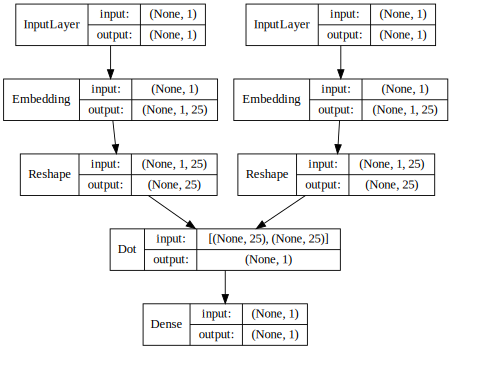

In [15]:
SVG(model_to_dot(final, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi= 65).create(prog='dot', format='svg'))

**The Whole Data numbers**

In [16]:
len(skip_gram)

99218

**Start Training!..**
---


**for training we first respectively get one mesra and in this mesra seperate the target words and context words. Then we feed these inputs to Network and by considering the labels for this mesra compute loss and backpropagation**.

---


***The above steps repeats in each epoch with shuffled data until the whole mesra are chosen.***

In [17]:
for epoch in range(1,16):

  loss =0
  shuffle(skip_gram) 

  for i ,elem in enumerate(skip_gram):

    pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    pair_second = list(zip(*elem[0]))[1]
    pair_second_elem = np.zeros([len(pair_second),1], dtype= 'int32')

    for j in range(len(pair_second)):
        pair_second_elem[j] = pair_second[j]

    labels = np.array(elem[1], dtype='int32')
    X = [pair_first_elem, pair_second_elem]
    Y = labels
    
    if i%10000 == 0:
       print('iteration {} in epoch {}'.format(i,epoch))
    loss += final.train_on_batch(X,Y)  

  print('Epoch:', epoch, 'Loss:', loss)





iteration 0 in epoch 1








iteration 10000 in epoch 1
iteration 20000 in epoch 1
iteration 30000 in epoch 1
iteration 40000 in epoch 1
iteration 50000 in epoch 1
iteration 60000 in epoch 1
iteration 70000 in epoch 1
iteration 80000 in epoch 1
iteration 90000 in epoch 1
Epoch: 1 Loss: 12571.093652579875
iteration 0 in epoch 2
iteration 10000 in epoch 2
iteration 20000 in epoch 2
iteration 30000 in epoch 2
iteration 40000 in epoch 2
iteration 50000 in epoch 2
iteration 60000 in epoch 2
iteration 70000 in epoch 2
iteration 80000 in epoch 2
iteration 90000 in epoch 2
Epoch: 2 Loss: 10754.913793760817
iteration 0 in epoch 3
iteration 10000 in epoch 3
iteration 20000 in epoch 3
iteration 30000 in epoch 3
iteration 40000 in epoch 3
iteration 50000 in epoch 3
iteration 60000 in epoch 3
iteration 70000 in epoch 3
iteration 80000 in epoch 3
iteration 90000 in epoch 3
Epoch: 3 Loss: 10503.812824343797
iteration 0 in epoch 4
iteration 10000 in epoch 4
iteration 20000 in epoch 4
iteration 30000

***get the weights of target embedding layer ***

In [18]:
word_layer = final.layers[2]
word_layer

In [19]:
weights = word_layer.get_weights()[0][1:]
print(weights.shape)

(17658, 25)


**Compute the distance matrix based on cosine distance**

In [20]:
distance_matrix = cosine_distances(weights)
print(np.shape(distance_matrix))
distance_matrix[1:10,1:10]

(17658, 17658)


array([[0.        , 0.02624208, 0.0657295 , 1.1905956 , 1.0713634 ,
        0.60361373, 0.03824985, 0.03947335, 0.03503382],
       [0.02624208, 0.        , 0.05186772, 1.0787213 , 0.97172034,
        0.50658417, 0.00976443, 0.02216315, 0.02573395],
       [0.0657295 , 0.05186772, 0.        , 1.0204382 , 0.9847491 ,
        0.47902066, 0.05252528, 0.0445376 , 0.06796014],
       [1.1905956 , 1.0787213 , 1.0204382 , 0.        , 0.17597705,
        0.29278314, 0.98882   , 0.98712605, 1.0537843 ],
       [1.0713634 , 0.97172034, 0.9847491 , 0.17597705, 0.        ,
        0.42921656, 0.887952  , 0.87740743, 0.9449757 ],
       [0.60361373, 0.50658417, 0.47902066, 0.29278314, 0.42921656,
        0.        , 0.42855996, 0.45879245, 0.4912603 ],
       [0.03824985, 0.00976443, 0.05252528, 0.98882   , 0.887952  ,
        0.42855996, 0.        , 0.01495522, 0.02388781],
       [0.03947335, 0.02216315, 0.0445376 , 0.98712605, 0.87740743,
        0.45879245, 0.01495522, 0.        , 0.03193009],


***Now find the 5 similar word to desired words ***

In [21]:
similar_words = { search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['گلاب','سیستان','ایران','رستم','خردمند']}

similar_words

{'ایران': ['ترکان', 'بار', 'گوش', 'جنگ', 'فرستاد'],
 'خردمند': ['پیر', 'باش', 'روشن', 'دار', 'پرستنده'],
 'رستم': ['نامور', 'پدید', 'بشنید', 'مهر', 'شده'],
 'سیستان': ['نظاره', 'یله', 'برند', 'دوال', 'بترسید'],
 'گلاب': ['پراگند', 'فروهشته', 'پرستندگان', 'رامش', 'ساج']}

**Below are the 5 similar word that i putted for the sake of caution**

![alt text](https://drive.google.com/uc?id=19rluF7I1aVcA7fjGuhQL1_QJEpw86eYS)